# Logistic Regression with a Neural Network Intuition

Build a logistic regression classifier to recognize cats.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset

%matplotlib inline

## Overview of the Problem Set

**Problem Statement:**   
We are given a dataset *data.h5* containing: 
- a training set of *m_train* images labeled as cat (y=1) or non-cat (y=0) 
- a test set of *m_test* images labeled as cat or non-cat 
- each image is of shape `(num_px, num_px, 3)` where *3 is for the 3 channels (RGB)*. Thus, each image is square `(height = num_px)` and `(width = num_px)`.

We will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

#### Load dataset

In [3]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

We added *"_orig"* at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with `train_set_x` and `test_set_x` (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your `train_set_x_orig` and `test_set_x_orig` is an array representing an image. We can visualize an example by running the following code.


y = 1 => 'cat' picture


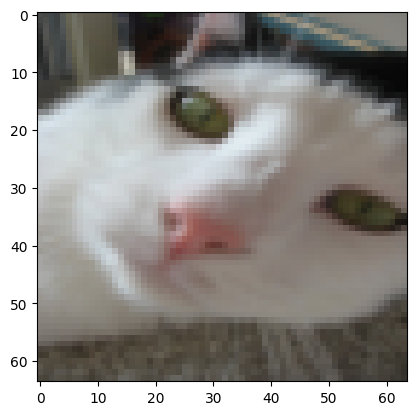

In [4]:
# Example of a picture
index = 14
plt.imshow(train_set_x_orig[index])
print (f"y = {train_set_y[0, index]} => '{classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}' picture")

y = 0 => 'non-cat' picture


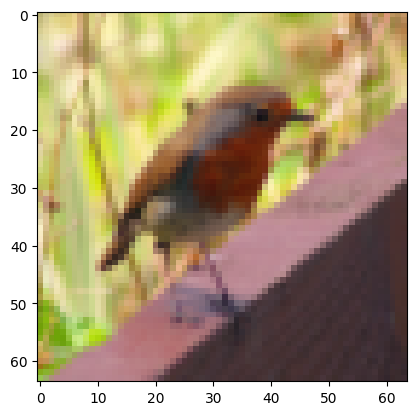

In [5]:
index = 10
plt.imshow(train_set_x_orig[index])
print (f"y = {train_set_y[0, index]} => '{classes[np.squeeze(train_set_y[:, index])].decode('utf-8')}' picture")

#### Pre-process

In [6]:
m_train = train_set_x_orig.shape[0] #number of training examples
m_test =  test_set_x_orig.shape[0]  #number of test examples
num_px = train_set_x_orig.shape[1]  #height = width of a training image

print(f"Number of training examples: m_train = {m_train}")
print(f"Number of testing examples: m_test = {m_test}")
print(f"Height/Width of each image: num_px = {num_px}")
print(f"Each image is of size: ({num_px}, {num_px}, 3)")
print(f"train_set_x shape: {train_set_x_orig.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x shape: {test_set_x_orig.shape}")
print(f"test_set_y shape: {test_set_y.shape}")

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


For convenience, we should now reshape images of shape (num_px, num_px, 3) to a numpy-array of shape `(num_px * num_px * 3, 1)`. After this, the training (and test) dataset is a numpy-array where each column represents a *flattened image*. There should be *m_train* (respectively *m_test*) columns.

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])

In [8]:
print(f"train_set_x_flatten shape: {train_set_x_flatten.shape}")
print(f"train_set_y shape: {train_set_y.shape}")
print(f"test_set_x_flatten shape: {test_set_x_flatten.shape}")
print(f"test_set_y shape: {test_set_y.shape}")
print(f"sanity check after reshaping: {train_set_x_flatten[0:5,0]}")

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and **standardize** your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array.  
But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

#### Standardize

In [9]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

## General Architecture of the Learning Algorithm

It's time to design a simple algorithm to distinguish cat images from non-cat images.

We will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!

![alt text](./images/LogReg_kiank.png)

#### Mathematical Expressions

For one example $x^{(i)}$:  
  
$$z^{(i)} = w^{T}x^{(i)} + b \\
\widehat{y} = a{(i)} = sigmoid(z^{(i)}) \\
L(a^{(i)}, y^{(i)}) = -y^{(i)}log(a^{(i)}) - (1 - y^{(i)})log(1 - a^{(i)})$$

The cost is then computed by summing over all the taining example:

$$J = \frac{1}{m} \sum_{i=1}^m L(a^{(i)}, y^{(i)})$$

The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)


In [10]:
def sigmoid(z: np.ndarray | int) -> float:
    """
    Compute the sigmoid of z

    Args:
        z (np.ndarray | int): A scalar or numpy array of any size

    Returns:
        float: sigmoid(z)
    """
    s = 1/(1+np.exp(-z))
    
    return s

In [11]:
print(f"sigmoid([0, 2]) = {sigmoid(np.array([0,2]))}")

sigmoid([0, 2]) = [0.5        0.88079708]


In [12]:
def initialize_with_zeros(dim: int) -> tuple:
    """
    Creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Args:
        dim (int): size of the w vector we want (or number of parameters in this case)

    Returns:
        w -- initialized vector of shape (dim, 1)
        b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [13]:
w, b = initialize_with_zeros(2)
print(f"w = {w}")
print(f"b = {b}")

w = [[0.]
 [0.]]
b = 0


## Forward Propagation:
- We get X
- Compute $A = \sigma(w^TX + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate cost $J = -\frac{1}{m} \sum_{i=1}^m y^{(i)}log(a^{(i)}) + (1 - y^{(i)})log(1 - a^{(i)})\\$

Here are the two derivative formulas: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X(A - Y)^T \\
\frac{\partial{J}}{\partial{b} = \frac{1}{m}}\sum_{i=1}^m(a^{(i)} - y^{(i)})$$

In [14]:
def propagate(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray) -> tuple:
    """
    Implement the cost function and its gradient for the propagation explained above

    Args:
        w (np.ndarray) -- weights, a numpy array of size (num_px * num_px * 3, 1)
        b (float) -- bias, a scalar
        X (np.ndarray) -- data of size (num_px * num_px * 3, number of examples)
        Y (np.ndarray) -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Returns:
        cost -- negative log-likelihood cost for logistic regression
        dw -- gradient of the loss with respect to w, thus same shape as w
        db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T,X) + b)                              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m   # compute cost

    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (np.dot(X,(A-Y).T))/m      # compute dJ/dw
    db = (np.sum(A-Y))/m            # compute dJ/db

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

In [15]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print(f"dw = {grads['dw']}")
print(f"db = {grads['db']}")
print(f"cost = {cost}")

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


## Optimization

- We have initialized your parameters.
- We are also able to compute a cost function and its gradient.
- Now, update the parameters using gradient descent.

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $\theta = \theta - \alpha\mathrm{d}\theta$, where is the learning rate.

In [16]:
def optimize(w: np.ndarray, b: float, X: np.ndarray, Y: np.ndarray, num_iterations: int, learning_rate: float, print_cost: bool = False) -> tuple:
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Args:  
        w (np.ndarray(num_px * num_px * 3, 1)) -- weights
        b (float) -- bias
        X (np.ndarray(num_px * num_px * 3, number of examples)) -- data
        Y (np.ndarray(1, number of examples)) -- true "label" vector (containing 0 if non-cat, 1 if cat)
        num_iterations (int) -- number of iterations of the optimization loop
        learning_rate (float) -- learning rate of the gradient descent update rule
        print_cost (bool) -- True to print the loss every 100 steps
    
    Returns:
        params -- dictionary containing the weights w and bias b
        grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
        costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w, "b": b}
    
    grads = {"dw": dw, "db": db}
    
    return params, grads, costs

In [17]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print(f"w = {params['w']}")
print(f"b = {params['b']}")
print(f"dw = {grads['dw']}")
print(f"db = {grads['db']}")

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


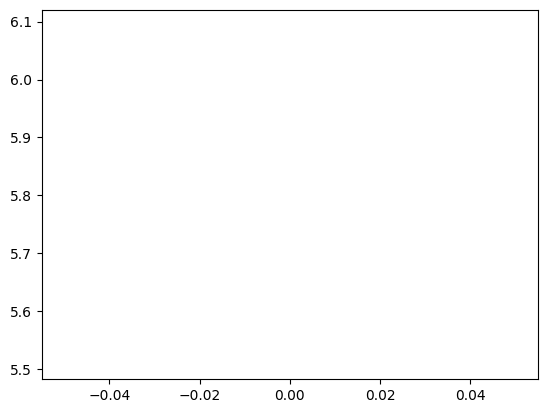

In [18]:
plt.plot(costs)

## Prediction

1. Calculate $\widehat{Y} = A = \sigma(w^TX + b)$
2. Convert the entries of $A$ into $0$ (if activation >=0.5) else $1$ and store the predictions in a vector `Y_prediction`.

In [19]:
def predict(w: np.ndarray, b: float, X: np.ndarray) -> np.ndarray:
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Args:
    w (np.ndarray(num_px * num_px * 3, 1))-- weights
    b (float)-- bias
    X (np.ndarray(num_px * num_px * 3, number of examples))-- data
    
    Returns:
        Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)  # Dimentions = (1, m)
    
    ## WORKING SOLUTION 1: USING IF ELSE ##
    # for i in range(A.shape[1]):
    #     # Convert probabilities A[0,i] to actual predictions p[0,i]
    #     if (A[0,i] >= 0.5):
    #        Y_prediction[0, i] = 1
    #     else:
    #        Y_prediction[0, i] = 0
        
    ##WORKING SOLUTION 2: ONE LINE ##
    # for i in range(A.shape[1]):
    #     # Convert probabilities A[0,i] to actual predictions p[0,i]
    #     Y_prediction[0, i] = 1 if A[0,i] >=0.5 else 0
    
    ## WORKING SOLUTION 3: VECTORISED IMPLEMENTATION ##
    Y_prediction = (A >= 0.5) * 1.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [20]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print(f"predictions = {predict(w, b, X)}")

predictions = [[1. 1. 0.]]


## Creating the Model

In [21]:
def model(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, num_iterations: int = 2000, learning_rate: float = 0.5, print_cost: bool = False) -> dict:
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train (ndarray(num_px * num_px * 3, m_train)) -- training set
    Y_train (ndarray(1, m_train)) -- training labels
    X_test (ndarray(num_px * num_px * 3, m_test)) -- test set
    Y_test (ndarray(1, m_test)) -- test labels
    num_iterations (int) -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate (float) -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost (bool) -- Set to true to print the cost every 100 iterations
    
    Returns:
    {"costs": costs, 
          "Y_prediction_test": Y_prediction_test, 
          "Y_prediction_train" : Y_prediction_train, 
          "w" : w, 
          "b" : b,
          "learning_rate" : learning_rate,
          "num_iterations": num_iterations
     }
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [22]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


Training accuracy is close to 100%. Test accuracy is 68%. The model is clearly overfitting the training data.

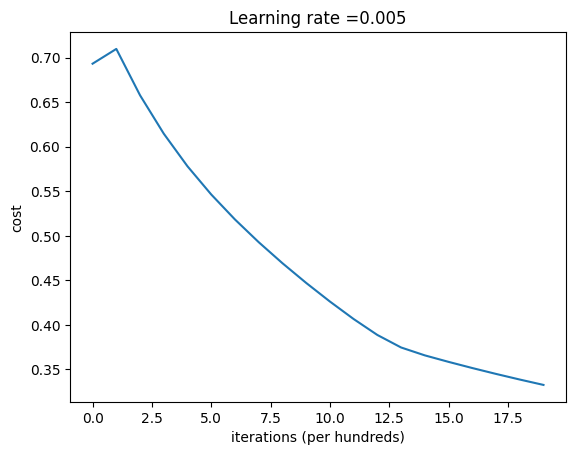

In [23]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

We can see the cost decreasing. It shows that the parameters are being learned. However, we see that we could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. We might see that the training set accuracy goes up, but the test set accuracy goes down. This is called **overfitting**.